In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from utils.preprocessing import normalize_data
import matplotlib.pyplot as plt

In [76]:
feature = 'cpu_system'

In [77]:
data = pd.read_csv('tachyon/far_data_2024-02-21_clustered.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['nodeId'].unique().shape

(195,)

In [78]:
time_series = []
for node_id in data['nodeId'].unique():
    ts = data[data['nodeId'] == node_id].reset_index(drop=True)
    time_series.append(ts)

In [79]:
time_series_0 = []
time_series_1 = []
time_series_2 = []
time_series_3 = []
for node_id in data['nodeId'].unique():
    ts = data[data['nodeId'] == node_id].reset_index(drop=True)
    if ts['Cluster'].iloc[0] == 0:
        time_series_0.append(ts)
    elif ts['Cluster'].iloc[0] == 1:
        time_series_1.append(ts)
    elif ts['Cluster'].iloc[0] == 2:
        time_series_2.append(ts)
    elif ts['Cluster'].iloc[0] == 3:
        time_series_3.append(ts)

In [80]:
len(time_series_0), len(time_series_1), len(time_series_2), len(time_series_3)

(59, 71, 25, 40)

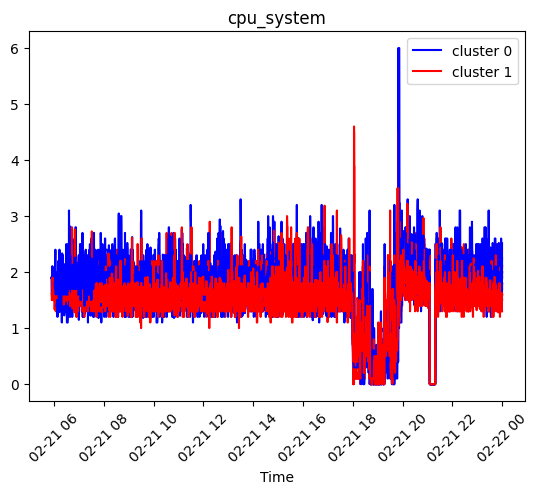

In [110]:
plt.figure()
for i in range(10):
    if i == 0:
        plt.plot(time_series_0[i]['timestamp'], time_series_0[i][feature], color="blue", label="cluster 0")
        plt.plot(time_series_1[i]['timestamp'], time_series_1[i][feature], color="red", label="cluster 1")
    else:
        plt.plot(time_series_0[i]['timestamp'], time_series_0[i][feature], color="blue")
        plt.plot(time_series_1[i]['timestamp'], time_series_1[i][feature], color="red")
plt.xticks(rotation=45)
plt.title(feature)
plt.xlabel('Time')
plt.legend()

Text(0.5, 0, 'Time')

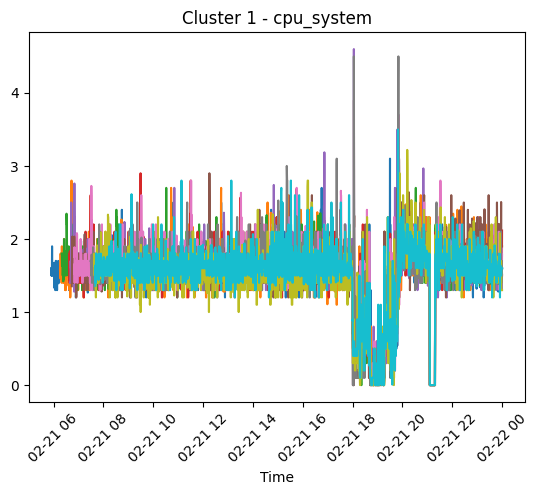

In [82]:
plt.figure()
for i in range(10):
    plt.plot(time_series_1[i]['timestamp'], time_series_1[i][feature])
plt.xticks(rotation=45)
plt.title('Cluster 1 - ' + feature)
plt.xlabel('Time')

In [83]:
def segment_time_series(series, segment_length = 600, step = 300):
    n = len(series)
    # Number of complete segments
    num_segments = n // step
    # Segment the series and assign the label to each segment
    segments = [
        series[i * step:i * step + segment_length:4].reset_index(drop=False)
        for i in range(num_segments) if i * step + segment_length < n
    ]
    return segments

In [84]:
segments = []
for i in range(10):
    # Segment the time series for each node
    # segments_i = segment_time_series(time_series_0[i])
    # segments_j = segment_time_series(time_series_1[i])
    segments_i = segment_time_series(time_series[i])
    segments.extend(segments_i)

In [85]:
# segemented time series and respective labels
segment_cpu = []
labels = []
for segment in segments:
    # Calculate the mean CPU usage for each segment
    cpu = segment[feature]
    label = segment['Cluster'][0]
    # if label == 2:
    #     label = 1
    # else:
    #     label = 0
    labels.append(label)
    segment_cpu.append(cpu)
    
print(labels[:20])
print(len(labels))

[np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]
130


In [86]:
normalize_segment_cpu, scaler = normalize_data(np.array(segment_cpu))

segment_array = normalize_segment_cpu.reshape(len(normalize_segment_cpu), 1, len(normalize_segment_cpu[0]))
labels = np.array(labels)

train_data, test_data, train_labels, test_labels = train_test_split(
    segment_array, labels, test_size=0.2, random_state=42, stratify=labels
)


In [87]:
from src.learning_shapelets import LearningShapelets
from tslearn.clustering import TimeSeriesKMeans
import random
import torch
from torch import nn, optim

In [88]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = np.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

In [89]:
def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

In [99]:
n_ts, n_channels, len_ts = train_data.shape
loss_func = nn.CrossEntropyLoss()

# Ensure labels are integer type and in the correct range
train_labels = train_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)


num_classes = len(np.unique(train_labels))
shapelets_size_and_len = {10: 10}
dist_measure = "euclidean"
lr = 1e-2
wd = 1e-3
epsilon = 1e-7
print(train_data.shape, test_data.shape)
learning_shapelets = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=True,
                                       verbose=1,
                                       dist_measure=dist_measure)
optimizer = optim.Adam(learning_shapelets.model.parameters(), lr=lr, weight_decay=wd, eps=epsilon)
learning_shapelets.set_optimizer(optimizer)
losses = learning_shapelets.fit(train_data, train_labels, epochs=3000, batch_size=256, shuffle=False, drop_last=False)




(104, 1, 150) (26, 1, 150)


Loss: 0.5307172536849976: 100%|██████████| 3000/3000 [00:32<00:00, 91.47it/s]


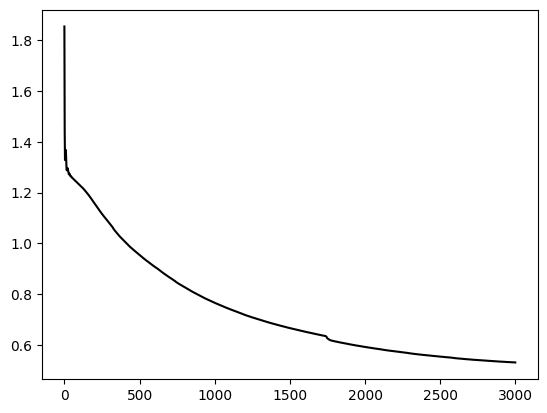

In [100]:
import matplotlib.pyplot as plt
plt.plot(losses, color="black")
plt.show()

In [101]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    

In [102]:
eval_accuracy(learning_shapelets, test_data, test_labels)

Accuracy: 0.5769230769230769


In [103]:
eval_accuracy(learning_shapelets, train_data, train_labels)

Accuracy: 0.8846153846153846


In [104]:
def torch_dist_ts_shapelet(ts, shapelet, cuda=True):
    """
    Calculate euclidean distance of shapelet to a time series via PyTorch and returns the distance along with the position in the time series.
    """
    
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    shapelet = torch.unsqueeze(shapelet, 0)
    # Remove trailing NaNs from shapelet
    if torch.isnan(shapelet).any():
        # Find the last non-NaN index along the last dimension
        valid_length = (~torch.isnan(shapelet[0, 0])).sum().item()
        shapelet = shapelet[:, :, :valid_length]
    # unfold time series to emulate sliding window\
    ts = ts.unfold(1, shapelet.shape[2], 1)
    # calculate euclidean distance
    dists = torch.cdist(ts, shapelet, p=2)
    dists = torch.sum(dists, dim=0)
    # otherwise gradient will be None
    # hard min compared to soft-min from the paper
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

In [105]:
def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = np.empty(pos)
    pad[:] = np.nan
    padded_shapelet = np.concatenate([pad, shapelet])
    return padded_shapelet

shapelets = learning_shapelets.get_shapelets()
shapelet_transform = learning_shapelets.transform(train_data)
a = 0
b = 1
dist_s1 = shapelet_transform[:, a]
dist_s2 = shapelet_transform[:, b]


In [106]:
np.sort(dist_s1)

array([0.86822146, 0.9264727 , 0.9390729 , 0.9390729 , 0.93974596,
       0.9411573 , 0.9564536 , 0.9606889 , 0.9649594 , 0.9817843 ,
       0.9963063 , 1.0035181 , 1.0053325 , 1.0079252 , 1.0194188 ,
       1.0256524 , 1.0272985 , 1.0302452 , 1.0302452 , 1.0313905 ,
       1.0332915 , 1.0348347 , 1.0384983 , 1.0384983 , 1.0454977 ,
       1.0516177 , 1.0615135 , 1.0653102 , 1.0687233 , 1.0691545 ,
       1.0691545 , 1.0720288 , 1.0776528 , 1.083043  , 1.0870308 ,
       1.0900521 , 1.0918889 , 1.0918889 , 1.0995471 , 1.0995471 ,
       1.1048441 , 1.1129987 , 1.1129987 , 1.1303976 , 1.1303976 ,
       1.1347119 , 1.1386267 , 1.1403084 , 1.1403576 , 1.1454481 ,
       1.1516436 , 1.1527966 , 1.1656629 , 1.1684263 , 1.1689627 ,
       1.1696477 , 1.169674  , 1.1723225 , 1.1839975 , 1.185277  ,
       1.1889961 , 1.1942061 , 1.194494  , 1.1959466 , 1.1994879 ,
       1.2045351 , 1.2045351 , 1.2048415 , 1.2094303 , 1.210483  ,
       1.2105669 , 1.2147902 , 1.2285686 , 1.2322974 , 1.23616

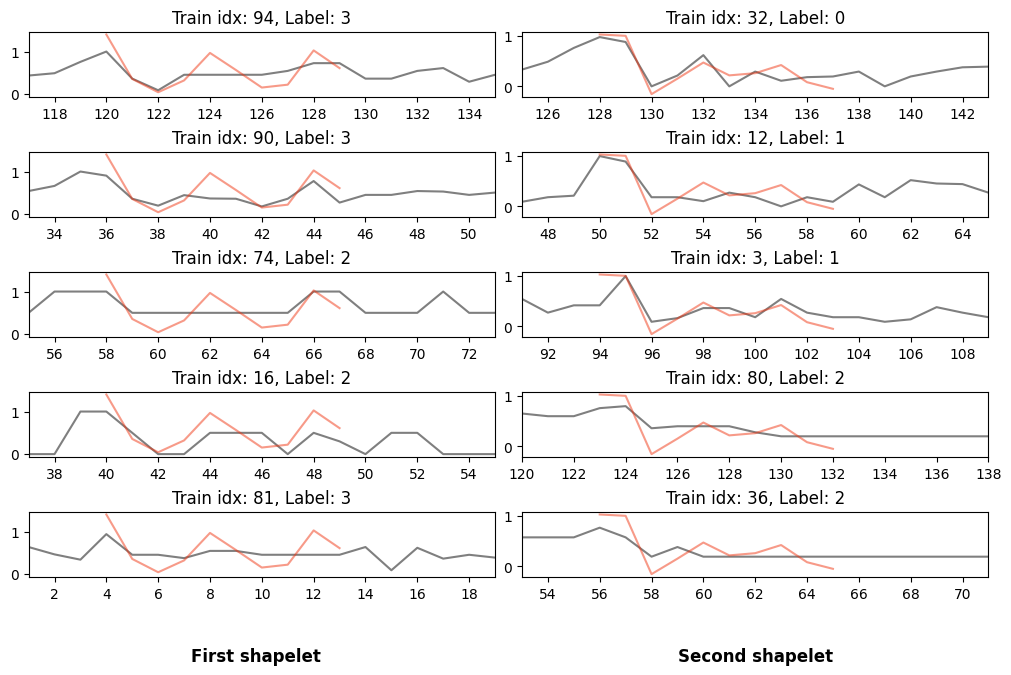

In [107]:

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(5, 8)
fig.text(0.25, -0.1, "First shapelet", ha='center', va='bottom', fontsize=12, fontweight='bold')
fig.text(0.75, -0.1, "Second shapelet", ha='center', va='bottom', fontsize=12, fontweight='bold')
for index, i in enumerate(np.argsort(dist_s1)[:25:5]):
    ax = fig.add_subplot(gs[index, :4])
    ax.plot(train_data[i, 0, :], color='black', alpha=0.5)
    _, pos = torch_dist_ts_shapelet(train_data[i], shapelets[0])
    ax.plot(lead_pad_shapelet(shapelets[a, 0], pos), color='#F03613', alpha=0.5)
    ax.set_xlim(pos-3, pos + 10 + 5)
    ax.set_title(f"Train idx: {i}, Label: {train_labels[i]}")
for index, i in enumerate(np.argsort(dist_s2)[:25:5]):
    ax = fig.add_subplot(gs[index, 4:])
    ax.plot(train_data[i, 0], color='black', alpha=0.5)
    _, pos = torch_dist_ts_shapelet(train_data[i], shapelets[1])
    ax.plot(lead_pad_shapelet(shapelets[b, 0], pos), color='#F03613', alpha=0.5)
    ax.set_xlim(pos-3, pos + 10 + 5)
    ax.set_title(f"Train idx: {i}, Label: {train_labels[i]}")

fig.savefig(f'tachyon/tachyon_shapelets_{feature}.png')

